In [1]:
import numpy as np
from numpy.linalg import det, inv, norm
from scipy.linalg import sqrtm

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", message="Casting complex values to real discards the imaginary part")

# Code and examples: gaussian process regression (univariate)

This section is inspired by [chapter 2](http://www.gaussianprocess.org/gpml/chapters/RW2.pdf), question 1 of GPML:

> Replicate the generation of random functions from Figure 2.2. Use a regular (or random) grid of scalar inputs and the covariance function from eq. (2.16). Hints on how to generate random samples from multi-variate Gaussian distributions are given in section A.2. Invent some training data points, and make random draws from the resulting GP posterior using eq. (2.19).

In [162]:
class GP:
    
    ############################################################################################
    # Initialize
    ############################################################################################
    def __init__(self, covariance_fn):
        self.cov   = covariance_fn
        self.X     = np.array([])
        self.y     = np.array([])
        self.K     = None
    
    ############################################################################################
    # Utilities
    ############################################################################################
    ###############################################################
    # Predict a new value
    # This shouldn't be its own function;
    # we do almost the same thing in mean_cov_at_new_points.
    # GPML, page 16
    ###############################################################
    def get_new_preds(self, new_point):
        # New point to predict
        # Only called when we have observed data!
        self.kinv = np.linalg.pinv(self.K)
        
        new_row   = [self.cov(new_point, xv) for xv in self.X]
        pred_mean = np.dot(np.dot(new_row, self.kinv), self.y)
        pred_2sds = 2 * np.sqrt(self.cov(new_point, new_point) - np.dot(np.dot(new_row, self.kinv), new_row))
        return pred_mean, pred_mean - pred_2sds, pred_mean + pred_2sds
    
    
    ###############################################################
    # Mean/Cov of GP conditioned on the observations
    # See GPML, page 16
    ###############################################################
    def mean_cov_at_new_points(self, locations):
        
        if self.K is not None:
            # We have some observations and we use them.
            # K* and K**
            self.kinv = np.linalg.pinv(self.K)
            ks        = np.array([[self.cov(l, xv) for xv in self.X] for l in locations])
            kss       = np.array([[self.cov(l, j) for l in locations] for j in locations])
            #print('ks', ks.shape)
            #print('kss', kss.shape)
            # The mean for the new point is:
            # (cov(x*, x).K^-1).y
            # Intuitively... decorrelate and then project onto y? That seems wrong.
            # What should the posterior mean be, if not this? 
            # http://www.cs.cmu.edu/~16831-f14/notes/F09/lec21/16831_lecture21.sross.pdf
            pred_mean = np.dot(ks, np.dot(self.kinv, self.y))
            pred_cov  = np.subtract(kss, np.dot(ks, np.dot(self.kinv, np.transpose(ks))))
        
            return pred_mean, pred_cov
        else: 
            # We have no observations, just sample from the prior:
            cov       = np.array([[self.cov(l, j) for l in locations] for j in locations])
            mean      = np.zeros(len(locations))
            return mean, cov
    
    ###############################################################
    # Generate samples from a multivariate Gaussian distribution:
    # https://en.wikipedia.org/wiki/Multivariate_normal_distribution
    # or GPML, appendix A
    # (alternatively just use built-in function)
    ###############################################################
    def draw_from_dist(self, how_many, mean_vector, covariance_matrix):
        # find A st A * A^T = covariance_matrix
        try:
            A = np.linalg.cholesky(covariance_matrix)
        except np.linalg.linalg.LinAlgError:
            # hack if positive semi-definite instead of positive definite
            #A = np.linalg.cholesky(np.add(covariance_matrix,  .1 * np.identity(len(covariance_matrix))))
            A = sqrtm(covariance_matrix)
            
        z = np.random.normal(0, 1, (how_many, covariance_matrix.shape[0]))
        return np.array([np.add(mean_vector, np.dot(A, x)) for x in z])
    
    ##########################
    # Observe
    ##########################
    def observe(self, X, y, noise = False, sigma = .3):
        self.X = np.concatenate((self.X, X))
        self.y = np.concatenate((self.y, y))
        # Should be reworked to not compute the whole thing every time:
        self.K = np.array([[self.cov(self.X[j], self.X[i]) for i in range(len(self.X))] for j in range(len(self.X))])
        if noise:
            # Page 16, eq 2.21
            self.K = self.K + sigma**2 * np.identity(len(self.K))
    
    def forget(self):
        self.X = np.array([])
        self.y = np.array([])
        self.K = None
        
    ##########################
    # Model assessment
    ##########################
    def model_log_likelihood(self):
        self.kinv = np.linalg.pinv(self.K)
        
        # predict new values
        ys        = np.dot(self.K, np.dot(self.kinv, self.y))
        
        kdet      = (lambda x: x if x != 0 else .0001)(np.linalg.det(self.K))
        
        pred_ll   = -.5 * (np.dot(np.dot(ys, self.kinv), ys) + np.log(kdet) + len(self.y)*np.log(2*np.pi))
        return pred_ll
   
    ##########################
    # Sample
    ##########################
    def sample(self, locations, how_many_fns=1):
        self.sample_locations = locations
        mean, covariance      = self.mean_cov_at_new_points(self.sample_locations)
        self.values           = self.draw_from_dist(how_many_fns, mean, covariance)
        # Sanity check: does mine look like the built-in?
        #self.values = np.random.multivariate_normal(mean, covariance, how_many_fns)
    
    ##########################
    # Plot
    ##########################
    def plot(self):
        if self.K is not None:
            alpha = .2
        else: 
            alpha = .8
            
        for i in range(len(self.values)):
            plt.plot(self.sample_locations, self.values[i], alpha=alpha)
        
        if self.K is not None:
            # mean, -2sd, +2sd
            vals = [self.get_new_preds(v) for v in self.sample_locations]
            plt.plot(self.sample_locations, [a for a, _, _ in vals], '-', color='k', alpha= 1)
            plt.plot(self.sample_locations, [a for _, a, _ in vals], '-', color='k', alpha=.5)
            plt.plot(self.sample_locations, [a for _, _, a in vals], '-', color='k', alpha=.5)

            # observed
            plt.plot(self.X, self.y, 'o', color = 'k');
        
def noisy_obs_title(model, sigma, ll):
    return model + ': Noisy Observations (SD of error = ' + str(sigma) + ')\nLog-likelihood: ' + str(ll)
def noise_free_title(model, ll): 
    return model + ": Noise-Free Observations\nLog-likelihood: " + str(ll)
def saw_nothing_title(model):
    return model + " (prior)"

## Examples

### Covariance function: squared exponential 

Squared exponential, given by $E^{-\frac{distance^2}{2*l}}$, where $l$ is the "characteristic length-scale". Intuitively, $l$ is a parameter telling us how close two points have to be to influence one another.


When $l$ is small, points are only influenced by close neighbors

When $l$ big, points influenced by distant points.

See page 83 GPML for more ([link](http://www.gaussianprocess.org/gpml/chapters/RW4.pdf)).

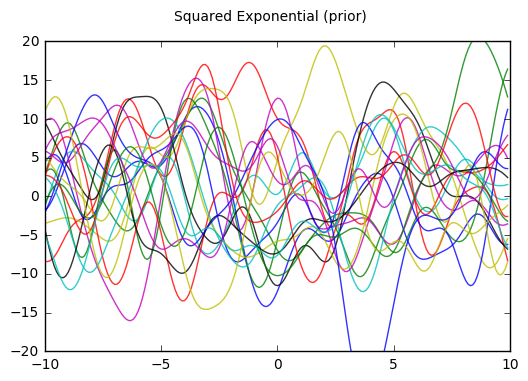

In [167]:
# Plot samples from the prior:

# Space to sample
sample_space = np.arange(-10, 10, .1);

# Kernel (note that it has a hyperparameter):
def cov(x1, x2):
    length_scale = .01;
    return np.exp(-.5 * np.linalg.norm(np.subtract(x2, x1))**2)/(2*length_scale)

gp = GP(cov); 
gp.sample(sample_space, 20); gp.plot()
p = plt.gcf(); ax = p.get_axes()[0]; ax.set_ylim([-20,20]);
p.suptitle(saw_nothing_title("Squared Exponential"));

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in sqrt


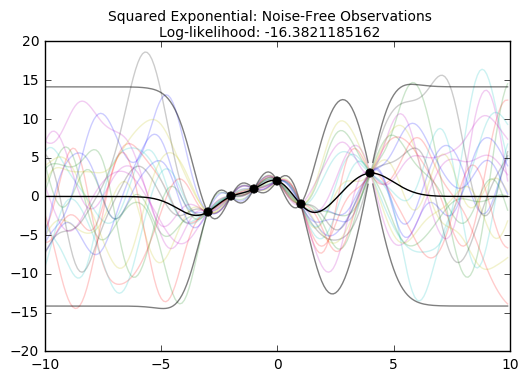

In [168]:
# Make some observations and plot the posterior:
X, y = np.array([-3., -2, -1, 0, 1, 4]), np.array([-2., 0, 1, 2, -1, 3])

gp.observe(X, y)

gp.sample(sample_space, 20); 

gp.plot();p = plt.gcf(); ax = p.get_axes()[0]; ax.set_ylim([-20,20]);
p.suptitle(noise_free_title("Squared Exponential", gp.model_log_likelihood()));

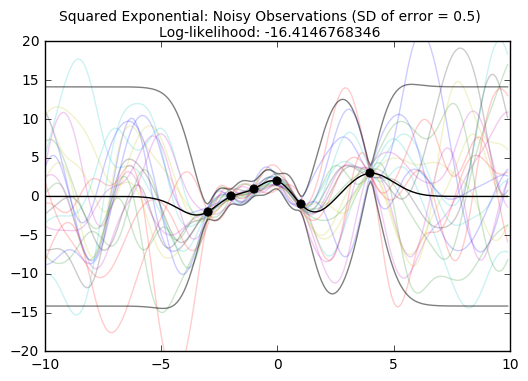

In [169]:
# Forget the things we've already seen. Make some noisy observations and plot the posterior:
sigma = .5

gp.forget()
gp.observe(X, y, noise = True, sigma = sigma)

gp.sample(sample_space, 20); gp.plot()
p = plt.gcf(); ax = p.get_axes()[0]; ax.set_ylim([-20,20]);
p.suptitle(noisy_obs_title("Squared Exponential", sigma, gp.model_log_likelihood()));

### Covariance function: rational quadratic


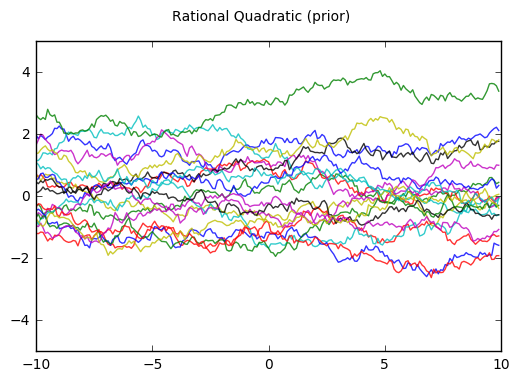

In [170]:
sample_space = np.arange(-10, 10, .1)

def cov(x1, x2):
    alpha = 10; l = 1;
    return (1 + np.linalg.norm(np.subtract(x2, x1)/(2*alpha*l)))**-l

gp = GP(cov)

gp.sample(sample_space, 20)
gp.plot(); p = plt.gcf(); ax = p.get_axes()[0]; ax.set_ylim([-5,5]);
p.suptitle(saw_nothing_title("Rational Quadratic"));

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in sqrt


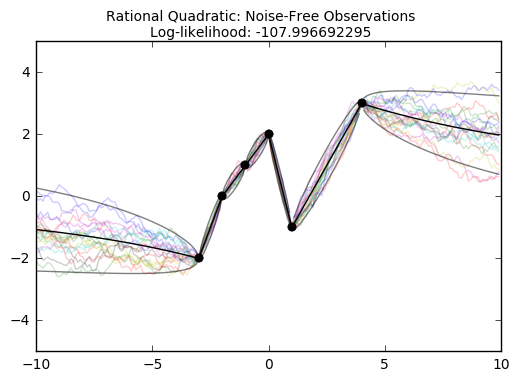

In [171]:
# Make some observations and plot the posterior:
X, y = np.array([-3., -2, -1, 0, 1, 4]), np.array([-2., 0, 1, 2, -1, 3])

gp.observe(X, y)
gp.sample(sample_space, 20)
gp.plot(); p = plt.gcf(); ax = p.get_axes()[0]; ax.set_ylim([-5,5]);
p.suptitle(noise_free_title("Rational Quadratic", gp.model_log_likelihood()));

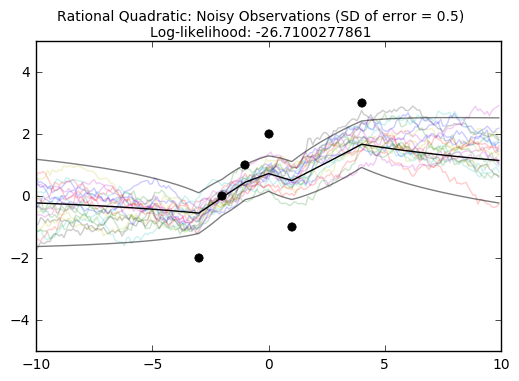

In [172]:
# Forget. Make some noisy observations and plot the posterior:
sigma = .5

gp.forget()
gp.observe(X, y, noise = True, sigma=sigma)
gp.sample(sample_space, 20)
gp.plot(); p = plt.gcf(); ax = p.get_axes()[0]; ax.set_ylim([-5,5]);
p.suptitle(noisy_obs_title("Rational Quadratic", sigma, gp.model_log_likelihood()));

### Covariance function: I don't know what this is called
[link](http://www.robots.ox.ac.uk/~mebden/reports/GPtutorial.pdf)

A squared exponential plus a periodic part:

$$\exp(\frac{-\sigma_f^2}{2l} \lvert{x_2 - x_1}\rvert^2) + \exp{(- 2 \sin( v \pi \lvert{x_2 - x_1}\rvert))^2}$$

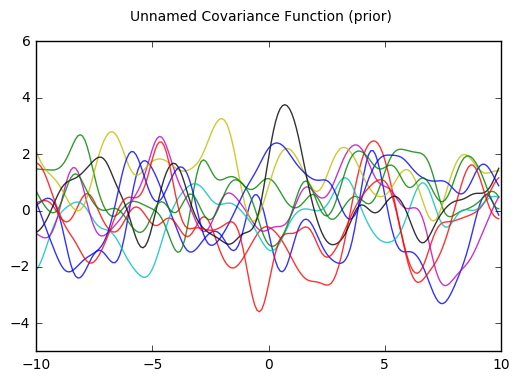

In [154]:
sample_space = np.arange(-10, 10, .1)

def cov(x1,x2):
    sigmaf = 1.269; l = 1; v = .20
    base = np.exp((-1/(2*l))*(sigmaf**2 * norm(np.subtract(x1,x2))**2)) + np.exp(-2*np.sin(v*np.pi*np.subtract(x1,x2))**2)
    return base 


gp = GP(cov)
gp.sample(sample_space, 10)
gp.plot(); p = plt.gcf(); ax = p.get_axes()[0]; ax.set_ylim([-5,6]);
p.suptitle(saw_nothing_title("Unnamed Covariance Function"));

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in sqrt


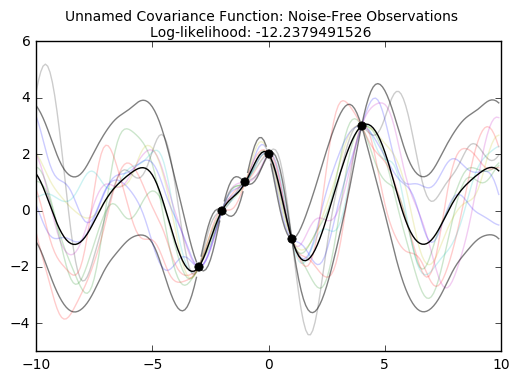

In [136]:
# Make some observations and plot the posterior:
X, y = np.array([-3., -2, -1, 0, 1, 4]), np.array([-2., 0, 1, 2, -1, 3])

gp.observe(X, y)
gp.sample(sample_space, 10)
gp.plot(); p = plt.gcf(); ax = p.get_axes()[0]; ax.set_ylim([-5,6]);
p.suptitle(noise_free_title("Unnamed Covariance Function", gp.model_log_likelihood()));

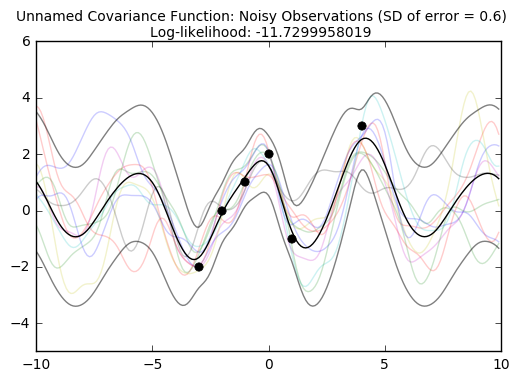

In [137]:
# Make some noisy observations and plot the posterior:
sigma = .6
gp.forget(); gp.observe(X, y, noise = True, sigma = sigma)
gp.sample(sample_space, 10)
gp.plot(); p = plt.gcf(); ax = p.get_axes()[0]; ax.set_ylim([-5,6]);
p.suptitle(noisy_obs_title("Unnamed Covariance Function", sigma, gp.model_log_likelihood()));

### Same function, different points

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in sqrt


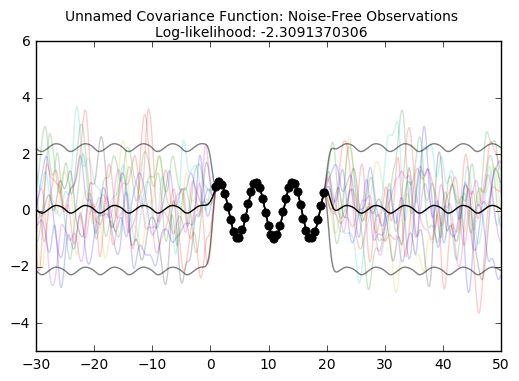

In [174]:
# How about different points?
# this one is slow
X = np.arange(1,20,.5) 
y = np.sin(X)
sample_space = np.arange(-30, 50, .1)

def cov(x1,x2):
    sigmaf =1.269; 
    l = 1; 
    v = .20
    
    base = np.exp((-1/(2*l))*(sigmaf**2 * norm(np.subtract(x1,x2))**2)) + np.exp(-2*np.sin(v*np.pi*np.subtract(x1,x2))**2)

    return base

gp = GP(cov)
gp.observe(X, y, noise = False)
gp.sample(sample_space, 10)
gp.plot(); p = plt.gcf(); ax = p.get_axes()[0]; ax.set_ylim([-5,6]);
p.suptitle(noise_free_title("Unnamed Covariance Function", gp.model_log_likelihood()));

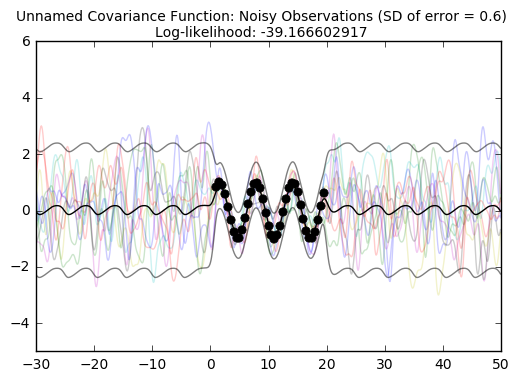

In [157]:
# Noise
sigma = .6

# Make some noisy observations and plot the posterior:
gp.forget(); gp.observe(X, y, noise = True, sigma = sigma)
gp.sample(sample_space, 10)
gp.plot(); p = plt.gcf(); ax = p.get_axes()[0]; ax.set_ylim([-5,6]);
p.suptitle(noisy_obs_title("Unnamed Covariance Function", sigma));

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in sqrt


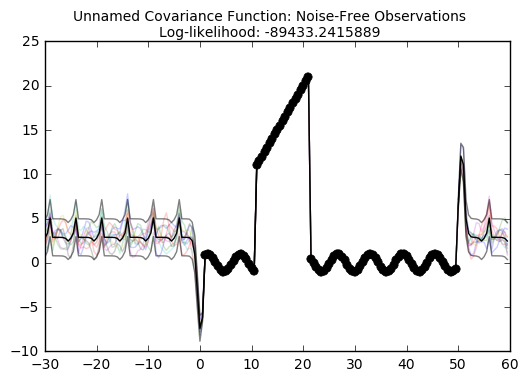

In [158]:
# Periodic followed by linear followed by periodic?
# Very weird...
X = np.arange(1,50,.5) 
y = np.concatenate((np.sin(X[:20]), X[20:41], np.sin(X[41:])))
sample_space = np.arange(-30, 60, .5)

gp.forget(); gp.observe(X, y, noise = False)
gp.sample(sample_space, 10)
gp.plot(); p = plt.gcf(); ax = p.get_axes()[0]; ax.set_ylim([-10,25]);
p.suptitle(noise_free_title("Unnamed Covariance Function", gp.model_log_likelihood()));

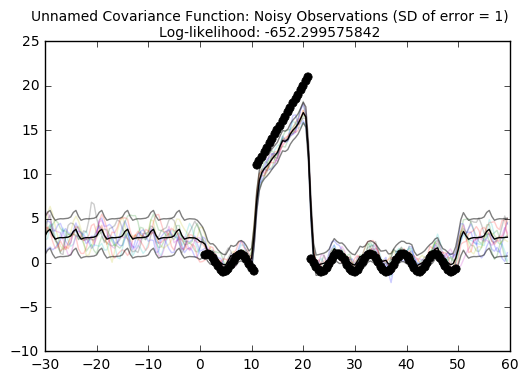

In [159]:
# Periodic followed by linear followed by periodic?

# Look at different sigmas.
sigma = 1

gp.forget(); gp.observe(X, y, noise = True, sigma = sigma)
gp.sample(sample_space, 10)
gp.plot(); p = plt.gcf(); ax = p.get_axes()[0]; ax.set_ylim([-10,25]);
p.suptitle(noisy_obs_title("Unnamed Covariance Function", sigma, gp.model_log_likelihood()));

# Problem 3 
### Brownian bridge/tied-down Wiener process

The Wiener process is defined for $x \geq 0$ and has $f(0) = 0$. (See section B.2.1 for further details.) It has mean zero and a non-stationary covariance function $k(x, x′) = min(x, x′)$. If we condition on the Wiener process passing through $f(1) = 0$ we obtain a process known as the Brownian bridge (or tied-down Wiener process). Show that this process has covariance $k(x,x′) = min(x,x′)−xx′$ for $0 \leq x, x′ \leq 1$ and mean $0$. Write a computer program to draw samples from this process at a finite grid of x points in $[0, 1]$.

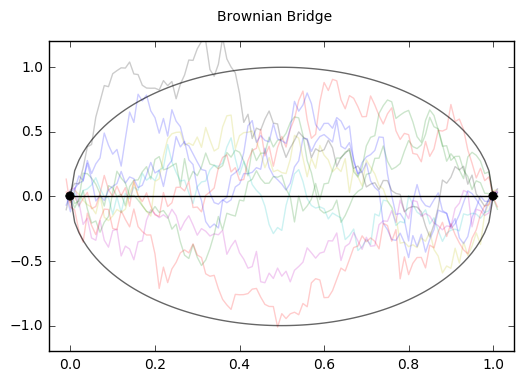

In [12]:
how_many     = 10
sample_space = np.arange(0-0.01, 1.02, .01)

def cov(x1,x2):
    return min(x1, x2) - x1*x2

# Observed data:
X    = np.array([0., 1])
y    = np.array([0., 0])
K    = np.array([[cov(a,b) for a in X] for b in X])

# Compute the mean vector and covariance matrix:
kinv = np.linalg.pinv(K)
ks        = np.array([[cov(l, xv) for xv in X] for l in sample_space])
kss       = np.array([[cov(l, j) for l in sample_space] for j in sample_space])
pred_mean = np.dot(ks, np.dot(kinv, y))
pred_cov  = np.subtract(kss, np.dot(ks, np.dot(kinv, np.transpose(ks))))

# Draw from distribution
A = sqrtm(pred_cov)
z = np.random.normal(0, 1, (how_many, pred_cov.shape[0]))
samples = np.array([np.add(pred_mean, np.dot(A, x)) for x in z])

sds  = [np.sqrt(cov(s, s) - (lambda x: np.dot(np.dot(x, kinv), x))([cov(s, xv) for xv in X])) for s in sample_space[1:-1]]

# And plot:
for i in range(len(samples)):
    plt.plot(sample_space, samples[i], alpha=.2)

plt.plot(sample_space, pred_mean, '-', color='k', alpha= 1)
plt.plot(sample_space[1:-1], [-2 * a for a in sds], '-', color='k', alpha=.6)
plt.plot(sample_space[1:-1], [ 2 * a for a in sds], '-', color='k', alpha=.6)

plt.plot(X, y, 'o', color = 'k');
plt.suptitle("Brownian Bridge")
p = plt.gcf(); ax = p.get_axes()[0]; ax.set_ylim([-1.2,1.2]); ax.set_xlim([-.05,1.05]);